In [1]:
#necessary imports
import pennylane as qml
import numpy as np
import torch
from torch.autograd import Variable

Preparing a unitary matrix

In [2]:
def initial_unitary():
    qml.RX(1.23,wires=0)
    qml.RY(-0.67,wires=0)
    qml.RZ(5.55,wires=0)

prep=qml.matrix(initial_unitary)()
print(prep)
#prep is the unitary matrix whixh needs to be prepared

[[-0.78810539-0.09940466j -0.44599413+0.41242921j]
 [ 0.44599413+0.41242921j -0.78810539+0.09940466j]]


In [3]:
deve = qml.device("default.qubit", wires=1)
@qml.qnode(deve, interface="torch")
def circui(A):
    
    initial_unitary()

    # returns the expectation of the input matrix A on the qubit
    return qml.expval(qml.Hermitian(A, wires=0))

finding out the bloch vector when unitary matrix acts on 0 state

In [4]:
Paulis = Variable(torch.zeros([3, 2, 2], dtype=torch.complex128), requires_grad=False)
Paulis[0] = torch.tensor([[0, 1], [1, 0]])
Paulis[1] = torch.tensor([[0, -1j], [1j, 0]])
Paulis[2] = torch.tensor([[1, 0], [0, -1]])
target_bloch=np.zeros(3)

for i in range(3):
    target_bloch[i]=(circui(Paulis[i]))
target_bloch

array([-0.78497552, -0.56140757,  0.26198277])

Array is converted to tensor

In [5]:
tar=Variable(torch.tensor(target_bloch))

In [6]:
tar

tensor([-0.7850, -0.5614,  0.2620], dtype=torch.float64)

In [7]:
nr_qubits = 3

Initialising random parameters

In [8]:
params = np.random.normal(0, np.pi, (nr_qubits, 3))
params = Variable(torch.tensor(params), requires_grad=True)

creating the circuit

In [9]:
def layer(params):
    for i in range(nr_qubits):
        qml.RX(params[i, 0], wires=i)
        qml.RY(params[i, 1], wires=i)
        qml.RZ(params[i, 2], wires=i)

    #entangling the qubits
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[1, 2])

In [10]:
dev = qml.device("default.qubit", wires=3)

In [11]:
@qml.qnode(dev, interface="torch")
def circuit(params, A):

    # apply each layer in the circuit
    
    layer(params)

    # returns the expectation of the input matrix A on the first qubit
    return qml.expval(qml.Hermitian(A, wires=0))

In [12]:
# cost function
def cost_fn(params):
    cost = 0
    for k in range(3):
        cost += torch.abs(circuit(params, Paulis[k]) - tar[k])# the expectation vaue of Pauli operators give thhe coordinates of the bloch vector

    return cost

First sphere marks the coordinate of the target bloch vector and the next sphere shows the trajectory of the bloch vector as the model trains

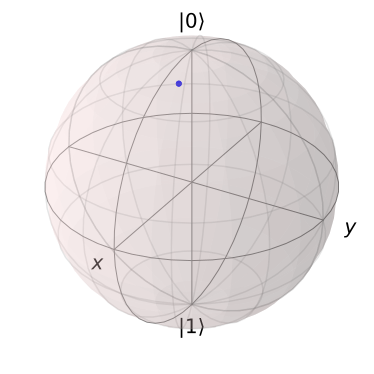

Cost after 0 steps is 1.5673
Cost after 10 steps is 0.2609
Cost after 20 steps is 0.1693
Cost after 30 steps is 0.0214
Cost after 40 steps is 0.0457
Cost after 50 steps is 0.0419
Cost after 60 steps is 0.0330
Cost after 70 steps is 0.0235
Cost after 80 steps is 0.0096
Cost after 90 steps is 0.0321
Cost after 100 steps is 0.0289
Cost after 110 steps is 0.0396
Cost after 120 steps is 0.0391
Cost after 130 steps is 0.0256
Cost after 140 steps is 0.0177
Cost after 150 steps is 0.0275
Cost after 160 steps is 0.0260
Cost after 170 steps is 0.0333
Cost after 180 steps is 0.0306
Cost after 190 steps is 0.0320
Cost after 200 steps is 0.0112
Target Bloch vector =  [-0.78497552 -0.56140757  0.26198277]
Output Bloch vector =  [-0.77825722 -0.57572798  0.25019226]


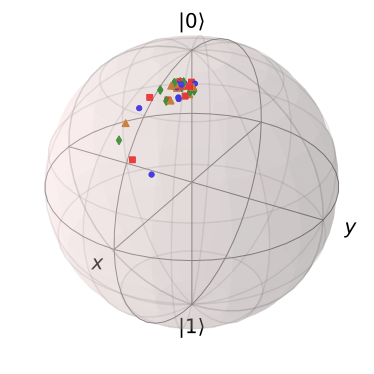

In [13]:
import qutip
import qutip
c = qutip.Bloch()
c.make_sphere()
c.add_points(tar)
c.render()
c.show()



# set up the optimizer
opt = torch.optim.Adam([params], lr=0.1)

# number of steps in the optimization routine
steps = 200

# the final stage of optimization isn't always the best, so we keep track of
# the best parameters along the way
best_cost = cost_fn(params)
best_params = np.zeros((nr_qubits, 3))

import qutip
b = qutip.Bloch()
b.make_sphere()

print("Cost after 0 steps is {:.4f}".format(cost_fn(params)))

# optimization begins
for n in range(steps):
    opt.zero_grad()
    loss = cost_fn(params)
    loss.backward()
    opt.step()

    # keeps track of best parameters
    if loss < best_cost:
        best_cost = loss
        best_params = params

    # Keep track of progress every 10 steps
    if n % 10 == 9 or n == steps - 1:
        print("Cost after {} steps is {:.4f}".format(n + 1, loss))
    
    inter_bloch_v = np.zeros(3)
    for l in range(3):
        inter_bloch_v[l] = circuit(params, Paulis[l])
#     from qiskit.visualization import plot_bloch_vector
#     %matplotlib inline
#     display(plot_bloch_vector(inter_bloch_v, title="N Bloch Sphere"))
    b.add_points(inter_bloch_v)
    b.render()

# calculate the Bloch vector of the output state
output_bloch_v = np.zeros(3)
for l in range(3):
    output_bloch_v[l] = circuit(best_params, Paulis[l])

# print results
print("Target Bloch vector = ", tar.numpy())
print("Output Bloch vector = ", output_bloch_v)
b.show()

In [14]:
best_params

tensor([[ 0.7590,  5.0645, -0.1537],
        [-1.6729,  4.7099, -1.4522],
        [-4.2285, -1.5705,  1.0874]], dtype=torch.float64, requires_grad=True)

The unitray matrix made by the RX, RY and RZ gate acting on the topmost qubit ie the unitary matrix made by the circuit

In [15]:
def circ():
    qml.RX(best_params[0,0],wires=0)
    qml.RY(best_params[0,1],wires=0)
    qml.RZ(best_params[0,2],wires=0)

prepared=qml.matrix(circ)()
print(prepared)

tensor([[-0.7757+0.1529j, -0.5534+0.2621j],
        [ 0.5534+0.2621j, -0.7757-0.1529j]], dtype=torch.complex128,
       grad_fn=<ReshapeAliasBackward0>)


The unitary matrix that was prepared

In [16]:
prep

array([[-0.78810539-0.09940466j, -0.44599413+0.41242921j],
       [ 0.44599413+0.41242921j, -0.78810539+0.09940466j]])

differnce of the two matrices

In [17]:
diff=prep-prepared.detach().numpy()
diff

array([[-0.01240488-0.25232574j,  0.10738495+0.15036916j],
       [-0.10738495+0.15036916j, -0.01240488+0.25232574j]])

Calculating the distance between learned and target unitary

In [22]:
from math import sqrt
D=0
for i in range(2):
    for j in range(2):
        D=D+(abs(diff[i,j]))**2   
D=math.sqrt(D)
D

0.4426388399552878

Answer 1. Code above

Answer 2. 3 qubits are required

Answer 3. 9 parameters had to be learnt (the rotation angles for RX, RY and RZ gate for all 3 qubits)

Answer 4. As I have worked with bloch vectors, the cost function for my code is abs(t<sub>1</sub>-l<sub>1</sub>)+abs(t<sub>2</sub>-l<sub>2</sub>)+abs(t<sub>3</sub>-l<sub>3</sub>) where (t<sub>1</sub>,t<sub>2</sub>,t<sub>3</sub>) is the target bloch vector and (l<sub>1</sub>,l<sub>2</sub>,l<sub>3</sub>) is the learnt bloch vector

Answer 5. D is calculated above

Answer 6 (bonus). The trajectory of the state vector along the bloch sphere
as your parameters evolve through the optimization procedure is plotted above.